In [1]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# computer vision library
import cv2

# glob
from glob import glob

In [2]:
fpath = (
    glob('./src/data/images/crop/female/**/*.jpg', recursive=True) +
    glob('./src/data/images/crop/female/**/*.jpeg', recursive=True) +
    glob('./src/data/images/crop/female/**/*.png', recursive=True)
)
mpath = (
    glob('./src/data/images/crop/male/**/*.jpg', recursive=True) +
    glob('./src/data/images/crop/male/**/*.jpeg', recursive=True) +
    glob('./src/data/images/crop/male/**/*.png', recursive=True)
)

In [3]:
def extract_identity(path):
    parts = path.replace("\\", "/").split('/')
    if 'known' in parts:
        return parts[parts.index('known') + 1]  # e.g., "julia" or "roope"
    elif 'unknown' in parts:
        return 'unknown'
    return 'unknown'  # fallback

In [4]:
df_female = pd.DataFrame(fpath, columns=['filepath'])
df_female['gender'] = 'female'
df_female['identity'] = df_female['filepath'].apply(extract_identity)

df_male = pd.DataFrame(mpath, columns=['filepath'])
df_male['gender'] = 'male'
df_male['identity'] = df_male['filepath'].apply(extract_identity)

In [5]:
df = pd.concat((df_female, df_male), axis=0, ignore_index=True)
df.head()
print("✅ Number of female images found:", len(fpath))
print("✅ Number of male images found:", len(mpath))
print("👀 First few female paths:", fpath[:5])
print("👀 First few male paths:", mpath[:5])

✅ Number of female images found: 2606
✅ Number of male images found: 2181
👀 First few female paths: ['./src/data/images/crop/female\\unknown\\female_0.jpg', './src/data/images/crop/female\\unknown\\female_1.jpg', './src/data/images/crop/female\\unknown\\female_100.jpg', './src/data/images/crop/female\\unknown\\female_1002.jpg', './src/data/images/crop/female\\unknown\\female_1005.jpg']
👀 First few male paths: ['./src/data/images/crop/male\\known\\Roope\\roope.jpg', './src/data/images/crop/male\\unknown\\male_0.jpg', './src/data/images/crop/male\\unknown\\male_1.jpg', './src/data/images/crop/male\\unknown\\male_1006.jpg', './src/data/images/crop/male\\unknown\\male_1008.jpg']


In [6]:
df.tail()

,filepath,gender,identity
4782,./src/data/images/crop/male\known\Roope\6fab94...,male,Roope
4783,./src/data/images/crop/male\known\Roope\cc9775...,male,Roope
4784,./src/data/images/crop/male\known\Roope\IMG_03...,male,Roope
4785,./src/data/images/crop/male\known\Roope\IMG_17...,male,Roope
4786,./src/data/images/crop/male\known\Roope\IMG_17...,male,Roope


In [7]:
def get_size(path):
    img = cv2.imread(path)
    return img.shape[0] if img is not None else 0

In [8]:
df['dimension'] = df['filepath'].apply(get_size)

In [9]:
df_filter = df.query('dimension > 60')

In [ ]:
def structuring(path):
    try:
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        size = gray.shape[0]
        if size >= 100:
            gray_resize = cv2.resize(gray, (100,100), cv2.INTER_AREA)
        else:
            gray_resize = cv2.resize(gray, (100,100), cv2.INTER_CUBIC)
        return gray_resize.flatten()
    except:
        return None

In [11]:

df_filter['data'] = df_filter['filepath'].apply(structuring)

C:\Users\roope\AppData\Local\Temp\ipykernel_55908\3588874944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['data'] = df_filter['filepath'].apply(structuring)


In [12]:
data = df_filter['data'].apply(pd.Series)
data.columns = [f"pixel_{i}" for i in data.columns]


In [13]:
data = data / 255.0

In [14]:
data['gender'] = df_filter['gender'].values
data['identity'] = df_filter['identity'].values

In [15]:
data.dropna(inplace=True)

In [19]:
dist_identity = df['identity'].value_counts()
dist_identity

identity
unknown    4761
Julia        20
Roope         6
Name: count, dtype: int64

In [20]:
dist_gender = df['gender'].value_counts()
dist_gender


gender
female    2606
male      2181
Name: count, dtype: int64

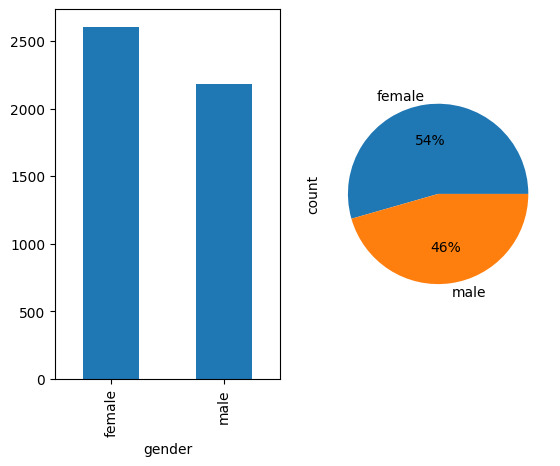

In [21]:
fig,ax = plt.subplots(nrows=1,ncols=2)
dist_gender.plot(kind='bar',ax=ax[0])
dist_gender.plot(kind='pie',ax=ax[1],autopct='%0.0f%%')
plt.show()

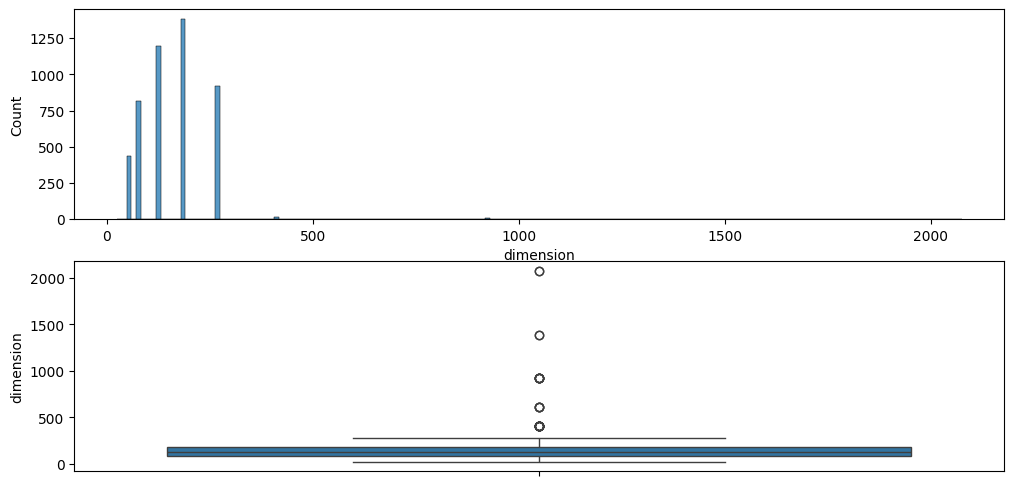

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
sns.histplot(df['dimension'])
plt.subplot(2,1,2)
sns.boxplot(df['dimension'])
plt.show()

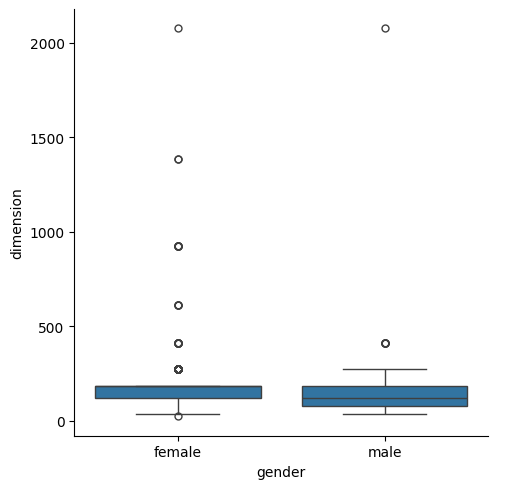

In [23]:
sns.catplot(data=df,x='gender',y='dimension',kind='box')